## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm # for progress bars.
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
#need to have bs4 installed using !pip install bs4
from bs4 import BeautifulSoup

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


### Loading my preprocessed dataset using pandas!

In [2]:
movie_reviews=pd.read_csv('/kaggle/input/moviespreproc/preprocessed_data.csv')
lengths_of_reviews = []
for x in movie_reviews["preprocessed_Reviews"] :
    lengths_of_reviews.append(len(x.split()))

movie_reviews["Length_of_PreprocReviews"] = lengths_of_reviews # adding length column to df
movie_reviews.columns           # prints all columns in dataframe



Index(['Review', 'Category', 'preprocessed_Reviews',
       'Length_of_PreprocReviews'],
      dtype='object')

## Split into XTrain, Ytrain , and XTest and YTest 80/20 split

In [3]:
sentiments = movie_reviews['Category'].values
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(movie_reviews["preprocessed_Reviews"],sentiments, test_size=0.2, random_state=42)

## Give Max review Length, Truncate Type and pre padding

In [4]:
Max_Review_Length = 250
forlargerReviews = "post"
forsmallerReviews = "pre"

In [5]:
special_token_for_padding = "<OOOOOOE>" #special token for words not in Vocabulary
# builds vocabulary like each unique word gets a integer ID in form of dictionary.
wrd = Tokenizer( char_level=False, oov_token = special_token_for_padding) #special_token_for_padding if word doesnt exist
wrd.fit_on_texts(X_train)
#total length of unique words in word index dictionary
len(wrd.word_index)

92722

In [6]:
size_of_vocabulary = len(wrd.word_index)+1 

In [7]:
unique_word_int_mappings = wrd.word_index
print('all unique words')
c = list(unique_word_int_mappings.keys())
c[0:10]


all unique words


['<OOOOOOE>',
 'movie',
 'film',
 'one',
 'like',
 'would',
 'good',
 'time',
 'even',
 'story']

In [8]:
print('Their respective int mappings')
c = list(unique_word_int_mappings.values())
c[0:10]

Their respective int mappings


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [9]:
# Get the first 5 key-value pairs
print('\nvocabulary of words - mappings \n')
top_5_pairs = list(unique_word_int_mappings.items())[:10]

# Print the top 5 key-value pairs
for key, value in top_5_pairs:
    print(f'Word: {key}, Index: {value}')


vocabulary of words - mappings 

Word: <OOOOOOE>, Index: 1
Word: movie, Index: 2
Word: film, Index: 3
Word: one, Index: 4
Word: like, Index: 5
Word: would, Index: 6
Word: good, Index: 7
Word: time, Index: 8
Word: even, Index: 9
Word: story, Index: 10


## Now converting each review from XTrain, Xtest into sequence of integer maps and padding :

In [10]:
XTrainsequenceofWordmaps = wrd.texts_to_sequences(X_train)
XTrainPaddedsequence = pad_sequences(XTrainsequenceofWordmaps, maxlen = Max_Review_Length, padding = forsmallerReviews, truncating = forlargerReviews )
XTestsequenceofWordmaps = wrd.texts_to_sequences(X_test)
XTestPaddedsequence = pad_sequences(XTestsequenceofWordmaps, maxlen = Max_Review_Length,padding = forsmallerReviews, truncating = forlargerReviews)

In [11]:
print('Movie Review before sequence of integer mapping:\n',X_train.iloc[5])
print('\nMovie Review after sequence of integer mapping :\n ',XTrainsequenceofWordmaps[5])
print('\nMovie Review after sequence of integer mapping & padded/truncated for max length: \n',XTrainPaddedsequence[5])

Movie Review before sequence of integer mapping:
 simple primitive evaluations simply say liked reasonably funny bits got great stars gorgeous look songs two repeated forgettable get healthy ironic treatment terribly handsome mr fairbanks exploding frenzied wagnerian version tender ballad miss grable rendered much dancing crinolines draped around miss grable comedy might bit heavy handed result still uplifting photography including real outdoor shots thrill amazing playing around different shades lush heavy gold miss grable bit past prime plumpish side still fresh comfortable continental olde worlde comedy pretty much along line earth rita hayworth one tends rather disliked many suppose several people would deem lady ermine outdated stuffy fairy tale tend move along certain paste anyhow suggestion enjoy artwork costumes witty script everything else film offer stop complaining film released dvd germany german english soundtrack

Movie Review after sequence of integer mapping :
  [454, 5

## LSTM's

In [12]:
import gensim
W2Vmodel = gensim.models.KeyedVectors.load_word2vec_format('../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin', binary=True)

In [13]:
allwords = list(W2Vmodel.key_to_index.keys())
Word2VecEmbeddings = {}
for x in allwords :
    Word2VecEmbeddings[x] = W2Vmodel[x]


In [14]:
print('words from Word2Vec Embeddings:')
allwords[0:5]

words from Word2Vec Embeddings:


['</s>', 'in', 'for', 'that', 'is']

In [15]:
print('words : words sequence mapping dictionary from Word2Vec Embeddings:')
top_3_pairs = list(Word2VecEmbeddings.items())[:3]

# Print the top 5 key-value pairs
for key, value in top_3_pairs:
    print(f'Word: {key}, Index: {value}')

words : words sequence mapping dictionary from Word2Vec Embeddings:
Word: </s>, Index: [ 1.1291504e-03 -8.9645386e-04  3.1852722e-04  1.5335083e-03
  1.1062622e-03 -1.4038086e-03 -3.0517578e-05 -4.1961670e-04
 -5.7601929e-04  1.0757446e-03 -1.0223389e-03 -6.1798096e-04
 -7.5531006e-04  1.4038086e-03 -1.6403198e-03 -6.3323975e-04
  1.6326904e-03 -1.0070801e-03 -1.2664795e-03  6.5231323e-04
 -4.1580200e-04 -1.0757446e-03  1.5258789e-03 -2.7465820e-04
  1.4019012e-04  1.5716553e-03  1.3580322e-03 -8.3160400e-04
 -1.4038086e-03  1.5792847e-03  2.5367737e-04 -7.3242188e-04
 -1.0538101e-04 -1.1672974e-03  1.5792847e-03  6.5612793e-04
 -6.5994263e-04  2.9206276e-06  1.1291504e-03  4.2724609e-04
 -3.7002563e-04 -1.1520386e-03  1.2664795e-03 -3.5166740e-06
  2.6512146e-04 -4.0245056e-04  1.4114380e-04 -3.3617020e-05
  7.5912476e-04 -5.1879883e-04 -7.1048737e-05  6.0272217e-04
 -5.0735474e-04 -1.6250610e-03 -4.3678284e-04 -9.9182129e-04
 -1.2207031e-03 -3.2234192e-04  6.8664551e-05 -1.1672974e-0

In [16]:
unmatched = []
matchedwordswithW2Vec = []
W2VecEmbeddings2d = np.zeros((size_of_vocabulary,300))
for word,indx in tqdm(wrd.word_index.items()):
    embedding_value = Word2VecEmbeddings.get(word)
    if embedding_value is not None:
        W2VecEmbeddings2d[indx] = embedding_value
        matchedwordswithW2Vec.append(word)
    else :
        unmatched.append(word)

100%|██████████| 92722/92722 [00:00<00:00, 279903.63it/s]


In [17]:
print('places Word2Vec word embedding sequence in the index of matched word in Vocabulary\n\n')
W2VecEmbeddings2d

places Word2Vec word embedding sequence in the index of matched word in Vocabulary




array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17480469, -0.10986328, -0.20019531, ...,  0.07958984,
         0.02807617, -0.02026367],
       ...,
       [ 0.02319336,  0.19433594, -0.16210938, ..., -0.37304688,
         0.18164062,  0.25390625],
       [-0.34570312,  0.15039062, -0.1953125 , ..., -0.12597656,
        -0.17871094,  0.26953125],
       [ 0.11181641,  0.08300781, -0.22363281, ..., -0.25390625,
         0.02331543,  0.52734375]])

In [18]:
print('\n\nlength of matched words from our vocabulary with that of Word2Vec words: \n')
len(matchedwordswithW2Vec)




length of matched words from our vocabulary with that of Word2Vec words: 



55414

In [19]:
print('\nmatched words')
matchedwordswithW2Vec[0:10]


matched words


['movie',
 'film',
 'one',
 'like',
 'would',
 'good',
 'time',
 'even',
 'story',
 'see']

In [20]:
lstm_units=256
dropofLSTM =0.3
lstm_W2Vec = Sequential()
lstm_W2Vec.add(Embedding(size_of_vocabulary, 300, input_length=Max_Review_Length, weights = [W2VecEmbeddings2d] , trainable = False))
lstm_W2Vec.add(LSTM(lstm_units, dropout=dropofLSTM))
lstm_W2Vec.add(Dense(1, activation='sigmoid'))
lstm_W2Vec.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 300)          27816900  
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 28,387,525
Trainable params: 570,625
Non-trainable params: 27,816,900
_________________________________________________________________


In [21]:
lstm_W2Vec.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
totalEpochs = 47
history = lstm_W2Vec.fit(XTrainPaddedsequence,Y_train, epochs=totalEpochs,validation_data=(XTestPaddedsequence, Y_test), verbose=2)

Epoch 1/47
1240/1240 - 27s - loss: 0.4294 - accuracy: 0.8086 - val_loss: 0.3667 - val_accuracy: 0.8369 - 27s/epoch - 22ms/step
Epoch 2/47
1240/1240 - 21s - loss: 0.3421 - accuracy: 0.8560 - val_loss: 0.3140 - val_accuracy: 0.8748 - 21s/epoch - 17ms/step
Epoch 3/47
1240/1240 - 21s - loss: 0.3027 - accuracy: 0.8747 - val_loss: 0.2773 - val_accuracy: 0.8890 - 21s/epoch - 17ms/step
Epoch 4/47
1240/1240 - 21s - loss: 0.2762 - accuracy: 0.8870 - val_loss: 0.2809 - val_accuracy: 0.8866 - 21s/epoch - 17ms/step
Epoch 5/47
1240/1240 - 21s - loss: 0.2588 - accuracy: 0.8938 - val_loss: 0.2603 - val_accuracy: 0.8957 - 21s/epoch - 17ms/step
Epoch 6/47
1240/1240 - 21s - loss: 0.2367 - accuracy: 0.9037 - val_loss: 0.2575 - val_accuracy: 0.8963 - 21s/epoch - 17ms/step
Epoch 7/47
1240/1240 - 21s - loss: 0.2174 - accuracy: 0.9130 - val_loss: 0.2710 - val_accuracy: 0.8939 - 21s/epoch - 17ms/step
Epoch 8/47
1240/1240 - 21s - loss: 0.1951 - accuracy: 0.9226 - val_loss: 0.2680 - val_accuracy: 0.8917 - 21s/ep

310/310 [==============================] - 2s 7ms/step
Accuracy of LSTM_WORD2VEC: 89.200%
Precision of LSTM_WORD2VEC: 86.889%
Recall of LSTM_WORD2VEC: 92.222%
F1 score of LSTM_WORD2VEC: 89.476%
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      4980
           1       0.87      0.92      0.89      4937

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



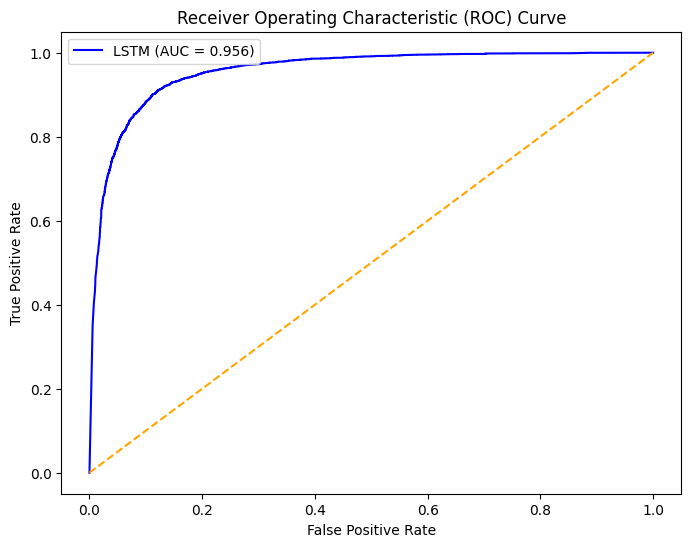

In [22]:
model = lstm_W2Vec
predictions = model.predict(XTestPaddedsequence, verbose=0)
predicted_sentiment = (model.predict(XTestPaddedsequence)>0.5).astype('int32')

predictions = predictions[:, 0]
predicted_sentiment = predicted_sentiment[:, 0]


accuracy = accuracy_score(Y_test, predicted_sentiment) * 100
precision = precision_score(Y_test, predicted_sentiment)* 100
recall = recall_score(Y_test, predicted_sentiment)* 100
f1 = f1_score(Y_test, predicted_sentiment)* 100

print(f'Accuracy of LSTM_WORD2VEC: {accuracy:.3f}%')
print(f'Precision of LSTM_WORD2VEC: {precision:.3f}%')
print(f'Recall of LSTM_WORD2VEC: {recall:.3f}%')
print(f'F1 score of LSTM_WORD2VEC: {f1:.3f}%')

matrix = classification_report(Y_test, predicted_sentiment)
print(matrix)

plt.figure(figsize=(8, 6))
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, predictions, pos_label=1)
random_false_positive_rate, random_true_positive_rate, _ = roc_curve(Y_test, np.zeros(len(Y_test)), pos_label=1)
auc_score = roc_auc_score(Y_test, predictions)

plt.plot(false_positive_rate, true_positive_rate, linestyle='-', color='blue', label='LSTM (AUC = {:.3f})'.format(auc_score))
plt.plot(random_false_positive_rate, random_true_positive_rate, linestyle='--', color='orange')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

## Bi-Directional LSTM's

In [23]:
dropofLSTM =0.3
BiLSTN_W2Vec = Sequential()
BiLSTN_W2Vec.add(Embedding(size_of_vocabulary, 300, input_length=Max_Review_Length, weights = [W2VecEmbeddings2d] , trainable = False))
BiLSTN_W2Vec.add(Bidirectional(LSTM(lstm_units, dropout=dropofLSTM, return_sequences=True)))
BiLSTN_W2Vec.add(Bidirectional(LSTM(lstm_units, dropout=dropofLSTM)))
BiLSTN_W2Vec.add(Dense(1, activation='sigmoid'))
BiLSTN_W2Vec.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [24]:
BiLSTN_W2Vec.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 300)          27816900  
                                                                 
 bidirectional (Bidirectiona  (None, 250, 512)         1140736   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 30,533,061
Trainable params: 2,716,161
Non-trainable params: 27,816,900
_________________________________________________________________


In [25]:
totalEpochs = 47
history = BiLSTN_W2Vec.fit(XTrainPaddedsequence, Y_train, epochs=totalEpochs, validation_data=(XTestPaddedsequence, Y_test), verbose=2)

Epoch 1/47
1240/1240 - 107s - loss: 0.4831 - accuracy: 0.7715 - val_loss: 0.3895 - val_accuracy: 0.8261 - 107s/epoch - 86ms/step
Epoch 2/47
1240/1240 - 98s - loss: 0.3496 - accuracy: 0.8511 - val_loss: 0.3347 - val_accuracy: 0.8615 - 98s/epoch - 79ms/step
Epoch 3/47
1240/1240 - 98s - loss: 0.3229 - accuracy: 0.8632 - val_loss: 0.2904 - val_accuracy: 0.8770 - 98s/epoch - 79ms/step
Epoch 4/47
1240/1240 - 98s - loss: 0.2972 - accuracy: 0.8773 - val_loss: 0.2689 - val_accuracy: 0.8905 - 98s/epoch - 79ms/step
Epoch 5/47
1240/1240 - 98s - loss: 0.2692 - accuracy: 0.8894 - val_loss: 0.2752 - val_accuracy: 0.8839 - 98s/epoch - 79ms/step
Epoch 6/47
1240/1240 - 98s - loss: 0.2514 - accuracy: 0.8962 - val_loss: 0.2628 - val_accuracy: 0.8945 - 98s/epoch - 79ms/step
Epoch 7/47
1240/1240 - 98s - loss: 0.2351 - accuracy: 0.9054 - val_loss: 0.2678 - val_accuracy: 0.8974 - 98s/epoch - 79ms/step
Epoch 8/47
1240/1240 - 98s - loss: 0.2262 - accuracy: 0.9091 - val_loss: 0.2669 - val_accuracy: 0.8957 - 98s/

310/310 [==============================] - 9s 30ms/step
Accuracy of BI-LSTM_WORD2VEC: 89.856%
Precision of BI-LSTM_WORD2VEC: 88.562%
Recall of BI-LSTM_WORD2VEC: 91.432%
F1 score of BI-LSTM_WORD2VEC: 89.974%
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4980
           1       0.89      0.91      0.90      4937

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



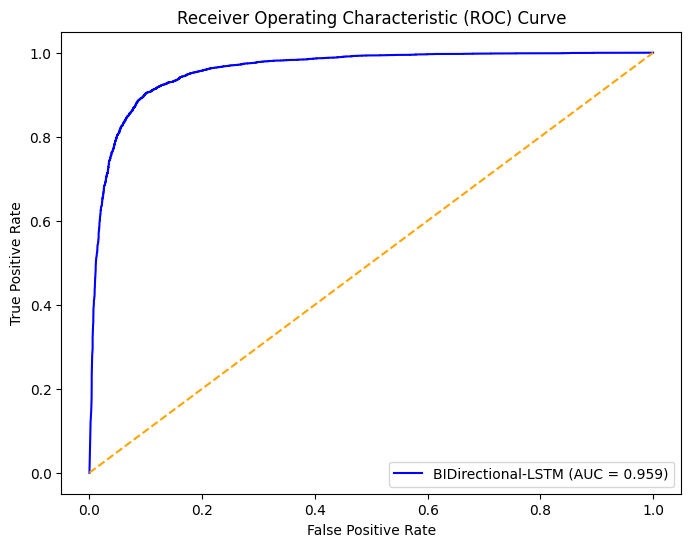

In [26]:
model = BiLSTN_W2Vec

predictions = model.predict(XTestPaddedsequence, verbose=0)

predicted_sentiment = (model.predict(XTestPaddedsequence)>0.5).astype('int32')

predictions = predictions[:, 0]
predicted_sentiment = predicted_sentiment[:, 0]

accuracy = accuracy_score(Y_test, predicted_sentiment) * 100
precision = precision_score(Y_test, predicted_sentiment)* 100
recall = recall_score(Y_test, predicted_sentiment)* 100
f1 = f1_score(Y_test, predicted_sentiment)* 100

print(f'Accuracy of BI-LSTM_WORD2VEC: {accuracy:.3f}%')
print(f'Precision of BI-LSTM_WORD2VEC: {precision:.3f}%')
print(f'Recall of BI-LSTM_WORD2VEC: {recall:.3f}%')
print(f'F1 score of BI-LSTM_WORD2VEC: {f1:.3f}%')


matrix = classification_report(Y_test, predicted_sentiment)
print(matrix)


plt.figure(figsize=(8, 6))
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, predictions, pos_label=1)
random_false_positive_rate, random_true_positive_rate, _ = roc_curve(Y_test, np.zeros(len(Y_test)), pos_label=1)
auc_score = roc_auc_score(Y_test, predictions)

plt.plot(false_positive_rate, true_positive_rate, linestyle='-', color='blue', label='BIDirectional-LSTM (AUC = {:.3f})'.format(auc_score))
plt.plot(random_false_positive_rate, random_true_positive_rate, linestyle='--', color='orange')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

## CNN-LSTM

In [27]:
from tensorflow.keras.layers import Conv1D,MaxPooling1D

dropofLSTM =0.3
CNN_LSTM_W2Vec = Sequential()
CNN_LSTM_W2Vec.add(Embedding(size_of_vocabulary, 300, input_length=Max_Review_Length, weights = [W2VecEmbeddings2d] , trainable = False))
CNN_LSTM_W2Vec.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
CNN_LSTM_W2Vec.add(MaxPooling1D(pool_size=2))
CNN_LSTM_W2Vec.add(LSTM(lstm_units, dropout=dropofLSTM))
CNN_LSTM_W2Vec.add(Dense(1, activation='sigmoid'))
CNN_LSTM_W2Vec.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_LSTM_W2Vec.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 300)          27816900  
                                                                 
 conv1d (Conv1D)             (None, 250, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 125, 32)          0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 256)               295936    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 28,141,925
Trainable params: 325,025
Non-trainable params: 27,816,900
____________________________________

In [28]:
totalEpochs = 47
history3 = CNN_LSTM_W2Vec.fit(XTrainPaddedsequence, Y_train, epochs=totalEpochs,validation_data=(XTestPaddedsequence, Y_test), verbose=2)

Epoch 1/47
1240/1240 - 18s - loss: 0.3801 - accuracy: 0.8322 - val_loss: 0.3951 - val_accuracy: 0.8299 - 18s/epoch - 14ms/step
Epoch 2/47
1240/1240 - 12s - loss: 0.2998 - accuracy: 0.8782 - val_loss: 0.2727 - val_accuracy: 0.8878 - 12s/epoch - 9ms/step
Epoch 3/47
1240/1240 - 12s - loss: 0.2769 - accuracy: 0.8898 - val_loss: 0.2657 - val_accuracy: 0.8946 - 12s/epoch - 9ms/step
Epoch 4/47
1240/1240 - 12s - loss: 0.2568 - accuracy: 0.8970 - val_loss: 0.2736 - val_accuracy: 0.8893 - 12s/epoch - 9ms/step
Epoch 5/47
1240/1240 - 12s - loss: 0.2426 - accuracy: 0.9023 - val_loss: 0.2614 - val_accuracy: 0.8948 - 12s/epoch - 9ms/step
Epoch 6/47
1240/1240 - 12s - loss: 0.2262 - accuracy: 0.9108 - val_loss: 0.2658 - val_accuracy: 0.8947 - 12s/epoch - 9ms/step
Epoch 7/47
1240/1240 - 12s - loss: 0.2083 - accuracy: 0.9202 - val_loss: 0.2633 - val_accuracy: 0.8932 - 12s/epoch - 9ms/step
Epoch 8/47
1240/1240 - 12s - loss: 0.1986 - accuracy: 0.9240 - val_loss: 0.2927 - val_accuracy: 0.8843 - 12s/epoch - 

310/310 [==============================] - 1s 4ms/step
Accuracy of CNNLSTM_WORD2VEC: 89.039%
Precision of CNNLSTM_WORD2VEC: 88.764%
Recall of CNNLSTM_WORD2VEC: 89.285%
F1 score of CNNLSTM_WORD2VEC: 89.024%
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4980
           1       0.89      0.89      0.89      4937

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



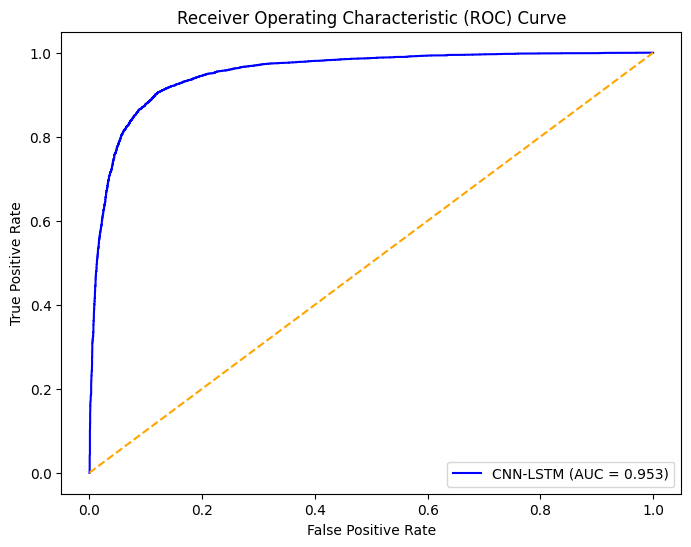

In [29]:
model = CNN_LSTM_W2Vec

predictions = model.predict(XTestPaddedsequence, verbose=0)

predicted_sentiment = (model.predict(XTestPaddedsequence)>0.5).astype('int32')

predictions = predictions[:, 0]
predicted_sentiment = predicted_sentiment[:, 0]

accuracy = accuracy_score(Y_test, predicted_sentiment) * 100
precision = precision_score(Y_test, predicted_sentiment)* 100
recall = recall_score(Y_test, predicted_sentiment)* 100
f1 = f1_score(Y_test, predicted_sentiment)* 100

print(f'Accuracy of CNNLSTM_WORD2VEC: {accuracy:.3f}%')
print(f'Precision of CNNLSTM_WORD2VEC: {precision:.3f}%')
print(f'Recall of CNNLSTM_WORD2VEC: {recall:.3f}%')
print(f'F1 score of CNNLSTM_WORD2VEC: {f1:.3f}%')


matrix = classification_report(Y_test, predicted_sentiment)
print(matrix)




plt.figure(figsize=(8, 6))
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, predictions, pos_label=1)
random_false_positive_rate, random_true_positive_rate, _ = roc_curve(Y_test, np.zeros(len(Y_test)), pos_label=1)
auc_score = roc_auc_score(Y_test, predictions)

plt.plot(false_positive_rate, true_positive_rate, linestyle='-', color='blue', label='CNN-LSTM (AUC = {:.3f})'.format(auc_score))
plt.plot(random_false_positive_rate, random_true_positive_rate, linestyle='--', color='orange')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

In [30]:
def removecontractionwords(foreachreview):
    foreachreview = re.sub(r"\'re", " are", foreachreview)
    foreachreview = re.sub(r"\'s", " is", foreachreview)
    
    foreachreview = re.sub(r"\'d", " would", foreachreview)
    foreachreview = re.sub(r"\'ll", " will", foreachreview)
    #seperating contractions of not
    foreachreview = re.sub(r"n\'t", " not", foreachreview)
    foreachreview = re.sub(r"\'t", " not", foreachreview)
    foreachreview = re.sub(r"won't", "will not", foreachreview)
    foreachreview = re.sub(r"can\'t", "can not", foreachreview)
    
    foreachreview = re.sub(r"\'ve", " have", foreachreview)
    foreachreview = re.sub(r"\'m", " am", foreachreview)
    return foreachreview

In [31]:
preprocessed_Text =[]

review= '''Now I am become death, the destroyer of worlds.
synystargates6 August 2023
Theory. Plutonium. Fire. Noise. Death. Morality. Compartmentalization. Oppenheimer.

I'm halfway through my Barbenheimer journey, and it's my first in-theater Christopher Nolan experience! I liked what I saw a lot, I love a good borderline psychological horror deep dive into a tortured soul. A film like Spencer comes to mind after watching something like this.

The moral conundrum between a scientific genius and the destruction he orchestrated is shown clearly in sequences before, during and after the bomb drops in Japan. The casting was perfect, the film is nothing short of a showcase in acting. It would've been nice to see more of Josh Peck and Devon Bostick, but everyone gives it their all here, especially Cillian Murphy & RDJ.

The runtime might be intimidating for some, but it's worth it because in my opinion, not a second is wasted. And that test bomb drop might be one of the most insane things ever made for a film. My jaw legitimately dropped wide open and I couldn't believe how lucky I was to be experiencing this moment in the theater.''' 
print('\n A 8 Star Review from IMDB :\n ',review)
for_each_review = re.sub(r"http\S+", "", review)
for_each_review = BeautifulSoup(for_each_review, 'html.parser').get_text()
for_each_review = removecontractionwords(for_each_review)
for_each_review = re.sub("\S*\d\S*", "", for_each_review).strip()
for_each_review = re.sub('[^A-Za-z]+', ' ', for_each_review)
for_each_review = ' '.join(word.lower() for word in for_each_review.split() 
                               if word.lower() not in stopwords.words('english'))
preprocessed_Text.append(for_each_review.strip())



token_sent = wrd.texts_to_sequences(preprocessed_Text)
test_pad_seq = pad_sequences(token_sent, maxlen = Max_Review_Length,padding = forsmallerReviews, truncating = forlargerReviews)

# Predict probabilities
predicted_probs = BiLSTN_W2Vec.predict(test_pad_seq)

# Convert probabilities to class predictions
predicted_classes = (predicted_probs > 0.5).astype('int32')

if predicted_classes[0][0] == 1 :
    print("\nSENTIMENT : It is a Positive Review 🎬:) ")
else :
    print("\nSENTIMENT : It is a Negative Review 🎬:( ")


 A 8 Star Review from IMDB :
  Now I am become death, the destroyer of worlds.
synystargates6 August 2023
Theory. Plutonium. Fire. Noise. Death. Morality. Compartmentalization. Oppenheimer.

I'm halfway through my Barbenheimer journey, and it's my first in-theater Christopher Nolan experience! I liked what I saw a lot, I love a good borderline psychological horror deep dive into a tortured soul. A film like Spencer comes to mind after watching something like this.

The moral conundrum between a scientific genius and the destruction he orchestrated is shown clearly in sequences before, during and after the bomb drops in Japan. The casting was perfect, the film is nothing short of a showcase in acting. It would've been nice to see more of Josh Peck and Devon Bostick, but everyone gives it their all here, especially Cillian Murphy & RDJ.

The runtime might be intimidating for some, but it's worth it because in my opinion, not a second is wasted. And that test bomb drop might be one of th

In [32]:
preprocessed_Text =[]

review= '''They found a way to make a nuclear bomb boring.
heatherworkmanrios30 July 2023
As a science nerd and someone who used to be obsessed with the Manhattan project, nuclear bombs etc. This really couldn't have been much worse. There were maybe 15 minutes of interesting tidbits related to themes Oppenheimer actually dealt with in his life and the rest was just garbage. It's like they tried to make it into a romcom/political film that had very little to do with the actual interesting parts of Oppenheimer's life. I won't write spoilers, but I promise you there is not much to spoil. Endless drivel, dialog that literally put me to sleep for a few minutes.

If you're interested in science and tech, just skip it. If you're interested in a good drama, skip it. If you like dull trials with too many actors and are really into dudes yelling every 5 minutes about "russia" or "communists" then go for it.'''
print('\nA 2 Star Review from IMDB :\n ',review)
for_each_review = re.sub(r"http\S+", "", review)
for_each_review = BeautifulSoup(for_each_review, 'html.parser').get_text()
for_each_review = removecontractionwords(for_each_review)
for_each_review = re.sub("\S*\d\S*", "", for_each_review).strip()
for_each_review = re.sub('[^A-Za-z]+', ' ', for_each_review)
for_each_review = ' '.join(word.lower() for word in for_each_review.split() 
                               if word.lower() not in stopwords.words('english'))
preprocessed_Text.append(for_each_review.strip())



token_sent = wrd.texts_to_sequences(preprocessed_Text)
test_pad_seq = pad_sequences(token_sent, maxlen = Max_Review_Length,padding = forsmallerReviews, truncating = forlargerReviews)

# Predict probabilities
predicted_probs = BiLSTN_W2Vec.predict(test_pad_seq)

# Convert probabilities to class predictions
predicted_classes = (predicted_probs > 0.5).astype('int32')

if predicted_classes[0][0] == 1 :
    print("\n SENTIMENT : It is a Positive Review 🎬:) ")
else :
    print("\n SENTIMENT : It is a Negative Review 🎬:( ")


A 2 Star Review from IMDB :
  They found a way to make a nuclear bomb boring.
heatherworkmanrios30 July 2023
As a science nerd and someone who used to be obsessed with the Manhattan project, nuclear bombs etc. This really couldn't have been much worse. There were maybe 15 minutes of interesting tidbits related to themes Oppenheimer actually dealt with in his life and the rest was just garbage. It's like they tried to make it into a romcom/political film that had very little to do with the actual interesting parts of Oppenheimer's life. I won't write spoilers, but I promise you there is not much to spoil. Endless drivel, dialog that literally put me to sleep for a few minutes.

If you're interested in science and tech, just skip it. If you're interested in a good drama, skip it. If you like dull trials with too many actors and are really into dudes yelling every 5 minutes about "russia" or "communists" then go for it.
1/1 [==============================] - 0s 28ms/step

 SENTIMENT : It